# Build and evalulate our model

We'll now import the latitude, longitude and weather data we collected and saved as pickle variables with the collect_and_clean_data.ipynb notebook

## Import required packages and cleaned variables 

In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import keras
from keras.layers import Input, Dense, concatenate, Conv1D, Conv2D, Flatten, BatchNormalization, Activation, GlobalMaxPool1D, MaxPooling2D, Dropout, GlobalMaxPool2D
from keras import regularizers
from keras.models import Model
import pickle
import inspect
import re
np.random.seed(123) #Control randomization 

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Import the elevation and weather data as a pickle file
Note: I imported the value as a pickle since it was easier to grab the nested arrays in cells out of that that than the csv which import as strings

In [2]:
with open('california_vineyards_elevation_weather.pkl', 'rb') as f: 
    elevation_weather_df = pickle.load(f)
    
#convert rows from a given column into a numpy array
def rows_to_2D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = ([row])
        else:
            arr = np.vstack([arr,row])
    return arr
    
#convert rows from a given column into a numpy array
def rows_to_3D_array(col):
    for i, row in enumerate(col):
        if i == 0:
            arr = np.array([row[0]])
        else:
            arr = np.concatenate([arr, np.array([row[0]])], axis=0)
    return arr

is_vineyard = np.array(elevation_weather_df['IsVineyard']).astype(float)
map_coords = rows_to_2D_array(elevation_weather_df['MapCoords'])
elevation = rows_to_3D_array(elevation_weather_df['ElevationMatrix'])
wind_dir = rows_to_2D_array(elevation_weather_df['WindDir'])
wind_spd = rows_to_2D_array(elevation_weather_df['WindSpd'])
precip = rows_to_2D_array(elevation_weather_df['Precip'])
temp = rows_to_2D_array(elevation_weather_df['Temp'])
min_temp = rows_to_2D_array(elevation_weather_df['MinTemp'])
max_temp = rows_to_2D_array(elevation_weather_df['MaxTemp'])
clouds = rows_to_2D_array(elevation_weather_df['Clouds'])
ghi = rows_to_2D_array(elevation_weather_df['GHI'])
rh = rows_to_2D_array(elevation_weather_df['RH'])

## Reserve portion of data for test set
Choose the number of addresses we want to leave as our test set

In [3]:
test_n = 40

## Clean missing data
Convert all missing values to the mean of each variable

In [4]:
#Replace missing values with mean of array
def replace_none(array):
    for subarray in array:
        subarray[subarray == None] = np.mean(subarray[subarray != None])
    
replace_none([map_coords, elevation, wind_dir, wind_spd, precip, temp, min_temp, max_temp, clouds, ghi, rh])

In [5]:
#Grab the number of dates collected in our weather variables to help shape our model structure
n_dates = len(wind_dir[1])

#Model structure
in_elevation = Input(shape=(5,5,), name='elevation')
in_map_coords = Input(shape=(2,), name='map_coords')
in_wind_dr = Input(shape=(n_dates,), name = 'wind_dir')
in_wind_spd = Input(shape=(n_dates,), name = 'wind_spd')
in_precip = Input(shape=(n_dates,), name = 'precip')
in_temp = Input(shape=(n_dates,), name = 'temp')
in_min_temp = Input(shape=(n_dates,), name = 'min_temp')
in_max_temp = Input(shape=(n_dates,), name = 'max_temp')
in_clouds = Input(shape=(n_dates,), name = 'clouds')
in_ghi = Input(shape=(n_dates,), name = 'ghi')
in_rh = Input(shape=(n_dates,), name = 'rh')

## Create dataframe to track performance of our model with different hyperparameters
We'll evaluate each run of our model with different settings by averaging training loss against validation loss. 

In [6]:
model_per_cols = ['BestLoss','Epoch','Dropout','KerReg','ActReg','HidDense','HidAct', 'FinAct', 'Batch', 'Vars']
model_perf_df = pd.DataFrame(columns=model_per_cols)

## Set hyperparameters
Save hyperparameters for training model to evaluate performance as we tweak the model

In [95]:
hidden_drop_out = 0.4
kern_regularizer = 0.0000001
act_regularizer = 0.0000001
hidden_dense_size = 100
hidden_activation = 'elu'
final_activation = 'sigmoid'
batch_size = 128
epochs = 100

In [96]:
x0 = in_elevation
x0 = Conv1D(4, kernel_size=(2))(x0)
x0 = BatchNormalization()(x0)
x0 = Activation(hidden_activation)(x0)
x0 = Dropout(hidden_drop_out)(x0)
x0 = GlobalMaxPool1D()(x0)

x1 = in_map_coords
x1 = BatchNormalization()(x1)
x1 = Activation(hidden_activation)(x1)
x1 = Dropout(hidden_drop_out)(x1)

x2= in_wind_dr
x2 = BatchNormalization()(x2)
x2 = Activation(hidden_activation)(x2)
x2 = Dropout(hidden_drop_out)(x2)

x3 = in_wind_spd
x3 = BatchNormalization()(x3)
x3 = Activation(hidden_activation)(x3)
x3 = Dropout(hidden_drop_out)(x3)

x4 = in_precip
x4 = BatchNormalization()(x4)
x4 = Activation(hidden_activation)(x4)
x4 = Dropout(hidden_drop_out)(x4)

x5 = in_temp
x5 = BatchNormalization()(x5)
x5 = Activation(hidden_activation)(x5)
x5 = Dropout(hidden_drop_out)(x5)

x6 = in_min_temp
x6 = BatchNormalization()(x6)
x6 = Activation(hidden_activation)(x6)
x6 = Dropout(hidden_drop_out)(x6)

x7 = in_max_temp
x7 = BatchNormalization()(x7)
x7 = Activation(hidden_activation)(x7)
x7 = Dropout(hidden_drop_out)(x7)

x8 = in_clouds
x8 = BatchNormalization()(x8)
x8 = Activation(hidden_activation)(x8)
x8 = Dropout(hidden_drop_out)(x8)

x9 = in_ghi
x9 = BatchNormalization()(x9)
x9 = Activation(hidden_activation)(x9)
x9 = Dropout(hidden_drop_out)(x9)

x10 = in_rh
x10 = BatchNormalization()(x10)
x10 = Activation(hidden_activation)(x10)
x10 = Dropout(hidden_drop_out)(x10)

#Choose which vars to include or drop
vars_used_str = 'x0,x1,x2,x4,x6,x7,x8,x9,x10' #string to save to performance dataframe
x = concatenate([x0,x1,x2,x4,x6,x7,x8,x9,x10])

x = Dense(hidden_dense_size, activation=hidden_activation, kernel_regularizer=regularizers.l2(kern_regularizer), activity_regularizer=regularizers.l2(act_regularizer))(x)
out = Dense(1, activation=final_activation)(x)

In [97]:
model = Model(inputs=[in_elevation, in_map_coords, in_wind_dr, in_wind_spd, in_precip, in_temp, in_min_temp, in_max_temp, in_clouds, in_ghi, in_rh], outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
elevation (InputLayer)          (None, 5, 5)         0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 4, 4)         44          elevation[0][0]                  
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 4, 4)         16          conv1d_10[0][0]                  
__________________________________________________________________________________________________
map_coords (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
wind_dir (

In [98]:
opt = keras.optimizers.nadam()
model.compile(optimizer=opt, loss='binary_crossentropy')
model_filepath='.weights.best.hdf5'

In [99]:
# Fit the model and save the history
history = model.fit([elevation[:-test_n], map_coords[:-test_n],wind_dir[:-test_n],wind_spd[:-test_n],precip[:-test_n], temp[:-test_n], min_temp[:-test_n], max_temp[:-test_n], clouds[:-test_n], ghi[:-test_n], rh[:-test_n]], is_vineyard[:-test_n], batch_size = batch_size, epochs=epochs, validation_split = 0.2)

Train on 687 samples, validate on 172 samples
Epoch 1/100
687/687 [==============================] - 5s 7ms/step - loss: 0.7486 - val_loss: 0.5407
Epoch 2/100
687/687 [==============================] - 0s 138us/step - loss: 0.5901 - val_loss: 0.4184
Epoch 3/100
687/687 [==============================] - 0s 138us/step - loss: 0.5299 - val_loss: 0.4825
Epoch 4/100
687/687 [==============================] - 0s 163us/step - loss: 0.4969 - val_loss: 0.4616
Epoch 5/100
687/687 [==============================] - 0s 158us/step - loss: 0.4804 - val_loss: 0.4348
Epoch 6/100
687/687 [==============================] - 0s 158us/step - loss: 0.4409 - val_loss: 0.4679
Epoch 7/100
687/687 [==============================] - 0s 160us/step - loss: 0.4614 - val_loss: 0.4143
Epoch 8/100
687/687 [==============================] - 0s 148us/step - loss: 0.4662 - val_loss: 0.4362
Epoch 9/100
687/687 [==============================] - 0s 149us/step - loss: 0.4549 - val_loss: 0.4462
Epoch 10/100
687/687 [=======

687/687 [==============================] - 0s 140us/step - loss: 0.3350 - val_loss: 0.3306
Epoch 80/100
687/687 [==============================] - 0s 168us/step - loss: 0.3282 - val_loss: 0.3328
Epoch 81/100
687/687 [==============================] - 0s 168us/step - loss: 0.3151 - val_loss: 0.3323
Epoch 82/100
687/687 [==============================] - 0s 126us/step - loss: 0.3266 - val_loss: 0.3457
Epoch 83/100
687/687 [==============================] - 0s 125us/step - loss: 0.3478 - val_loss: 0.3240
Epoch 84/100
687/687 [==============================] - 0s 134us/step - loss: 0.3252 - val_loss: 0.3143
Epoch 85/100
687/687 [==============================] - 0s 135us/step - loss: 0.3134 - val_loss: 0.3469
Epoch 86/100
687/687 [==============================] - 0s 134us/step - loss: 0.3413 - val_loss: 0.3173
Epoch 87/100
687/687 [==============================] - 0s 171us/step - loss: 0.3076 - val_loss: 0.3490
Epoch 88/100
687/687 [==============================] - 0s 163us/step - loss:

## Track performance of each model run during experimentation

First we'll track the best validation loss value along with the epoch we achieved that low loss on.

In [100]:
#Convert the history of the model run across epochs to lists
loss_results = history.history.get('loss')
val_loss_results = history.history.get('val_loss')

best_loss = 10 #set it to an arbitrary high loss number
best_epoch = 0

i = 0
while i < len(val_loss_results):
    #Store the best loss value across epochs
    if (val_loss_results[i] < best_loss):
        best_loss = val_loss_results[i]
        best_epoch = i + 1 # we add 1 since epoch start from an index of 1 instead of 0
        
    i = i +1

## Plot training loss vs validation loss over epochs

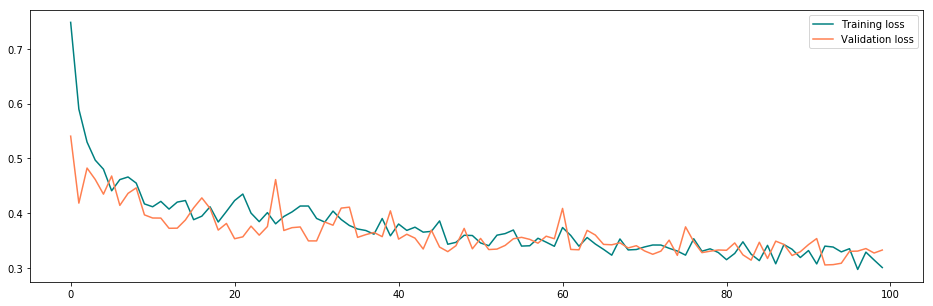

In [101]:
#Plot performance over epochs
from matplotlib import pyplot as plt

#Create ticks on x axis from 0 through the number of epochs
x = np.arange(0,epochs)

lines = [loss_results,val_loss_results]
colors  = ['teal','coral']
labels  = ['Training loss','Validation loss']

# Adjust default plot size
plt.figure(figsize=(16,5))

for i,c,l in zip(lines,colors,labels):  
    plt.plot(x,i,c,label='l')
    plt.legend(labels)
               
plt.show()

Print results of all runs to help guide future model experimentation

In [102]:
#Save model performance to dataframe
model_perf_df.loc[len(model_perf_df)] = [format(best_loss, '.4f'), best_epoch, hidden_drop_out, kern_regularizer, act_regularizer, hidden_dense_size, hidden_activation, final_activation, batch_size, vars_used_str] 

#Print dataframe with model performance
print(model_perf_df.to_string(index=False))

BestLoss Epoch  Dropout        KerReg        ActReg HidDense HidAct   FinAct Batch                         Vars
 0.3355    99     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   128      x0,x1,x2,x4,x6,x7,x8,x9
 0.3181    91     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   128  x0,x1,x2,x4,x6,x7,x8,x9,x10
 0.3210    90     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   128     x0,x2,x4,x6,x7,x8,x9,x10
 0.3307    93     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   100  x0,x1,x2,x4,x6,x7,x8,x9,x10
 0.3321    86     0.45  1.000000e-07  1.000000e-07      100    elu  sigmoid   150  x0,x1,x2,x4,x6,x7,x8,x9,x10
 0.3141   100     0.40  1.000000e-07  1.000000e-07      100    elu  sigmoid   128  x0,x1,x2,x4,x6,x7,x8,x9,x10
 0.3442    11     0.35  1.000000e-07  1.000000e-07      100    elu  sigmoid   128  x0,x1,x2,x4,x6,x7,x8,x9,x10
 0.3268   180     0.42  1.000000e-07  1.000000e-07      100    elu  sigmoid   128  x0,x1,x2,x4,x6,x7,x8,x9,x10


## Test model against test set
Test model against test set by rounding the predictions which are decimals to True / False values. Then, create an array which tracks whether or not the model predicted correctly predicted whether or not a location was a vineyard or not. 

In [103]:
#get predictions with probability values
y_hat = model.predict([elevation[-test_n:], map_coords[-test_n:],wind_dir[-test_n:],wind_spd[-test_n:],precip[-test_n:], temp[-test_n:], min_temp[-test_n:], max_temp[-test_n:], clouds[-test_n:], ghi[-test_n:], rh[-test_n:]], verbose=1)

#Round probabilities to 1s or 0s to test the accuracy of our train 
accuracy = np.array([])
i = 0
while i < len(y_hat):
    rounded_predict = round(y_hat[i][0])
    
    #Was the prediction correct?
    correct = rounded_predict == is_vineyard[-test_n:][i]
    accuracy = np.append(accuracy, correct)
    
    i = i +1

40/40 [==============================] - 1s 25ms/step


Percent of locations classified correctly in our test set...

In [104]:
print('Correct responses = ' + str(np.mean(accuracy)*100) + '%')

Correct responses = 90.0%
